# QAOA for the Max-Cut
First we import the needed libraries

In [32]:
%matplotlib inline
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt 

from qiskit import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize, LinearConstraint, differential_evolution

Then we generate graph G(E,V) with n=|V| nodes and m=|E| edges.

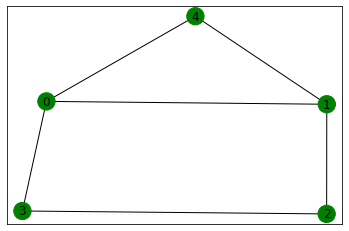

In [45]:
# Generating the graph G(V,N) 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0), (1,2,1.0),(2,3,1.0),(3,0,1.0),(0,4,1.0),(1,4,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
nx.draw_networkx(G, node_color=colors)


Now we define a function that takes the parameters $\gamma$ and $\beta$ and makes a circuit that implements the gates $U = e^{-i\gamma H}$ and $U = e^{-i\beta H_{mixing}}$ and measures all the qubits. Then it executes the circuit a number of times given by the parameter shots, and returns the number of counts of every measured n-qubit state. 

In [46]:
def quantum_circuit(G, gamma, beta, backend, shots): #returns an instance of the Results class

    n = len(G.nodes())

    QAOA = QuantumCircuit(n, n)
    QAOA.h(range(n))
    for edge in E:
        k = edge[0]
        l = edge[1]
        QAOA.cu1(-2*gamma, k, l)
        QAOA.u1(gamma, k)
        QAOA.u1(gamma, l)

    QAOA.rx(2*beta, range(n))
    QAOA.measure(range(n),range(n))

    job = execute(QAOA, backend=backend, shots=shots)
    #job_monitor(job)
    results = job.result()
    counts = results.get_counts() #dictionary with keys 'bit string x' and items 'counts of x'
    return counts

This function takes a bit string x representing a state and measures the cost of the state represented by that bitstring. 

In [47]:

def cost_function_C(x,G): #input x is a list
    E = G.edges()
    C = 0
    for vertice in E:
        e1 = vertice[0]
        e2 = vertice[1]
        w = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    return C

Finally, we need to calculate the expectation value of the cost function in the final state, by summing the cost of every measured state in the final state |bra$\gamma$,$\beta$>. We also define a function that returns the solution state and the cost function of that state (the solution is taken to be the state with the highest cost function within all the measured states)

In [48]:
def get_expectval(counts, shots):
    total_cost = 0
    for sample in list(counts.keys()):
        x = [int(bit_num) for bit_num in list(sample)] #the bit string is saved as a list
        cost_x = cost_function_C(x,G)
        total_cost += counts[sample]*cost_x
    avr_cost = total_cost/shots
    return avr_cost

def get_solution(counts):
    solution_cost = 0
    for sample in list(counts.keys()):
        x = [int(bit_num) for bit_num in list(sample)] #the bit string is saved as a list
        cost_x = cost_function_C(x,G)
        if cost_x > solution_cost:
            solution = x
            solution_cost = cost_x
    print(f'The solution is the state {solution} with a cost value of {solution_cost}')
    return solution, solution_cost

# Local simulator
## Solutions grid
We now represent the cost function over the $\gamma,\beta$ space. In this particular graph $\gamma$ is periodic in (0,$2\pi$) and $\beta$ is periodic in (0,$\frac{\pi}{2}$). In general?? See appendix of the paper Improving the Performance of Deep Quantum Optimization Algorithms
with Continuous Gate Sets

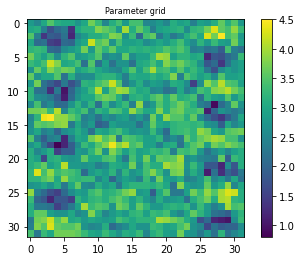

In [49]:
backend = Aer.get_backend("qasm_simulator")
shots = 10
avr_cost_grid = np.zeros((32,32))

for gamma in np.arange(0, 6.4, 0.2): #gamma and beta grid
    for beta in np.arange(0, 6.4, 0.2):

        counts = quantum_circuit(G, gamma, beta, backend, shots)
        avr_cost = get_expectval(counts, shots)

        avr_cost_grid[int(beta*5),int(gamma*5)] = avr_cost

plt.imshow(avr_cost_grid) #alpha->x axis, beta->y axis #gamma is periodic in (0,pi) and beta in (0,2pi)
plt.title('Parameter grid', fontsize=8)
plt.colorbar()
plt.show()

## Optimizing the expectation value of the cost function
We need a float objective function to minimize that takes gamma and beta and returns the negative of the expectation value of the cost function ( the negative because we want to maximize the expectation value). In the case of a 2 node graph, the solution's states are 01 and 10, and the maximum value of the cost function is 1. 

In [50]:
def expect_value_function(parameters, backend, G, shots):
    gamma = parameters[0]
    beta = parameters[1]
    counts = quantum_circuit(G,gamma,beta,backend,shots)
    avr_cost = get_expectval(counts, shots)
    return -avr_cost

When using a local optimizer method (Sequential Least Squares Programming) it doesn't seem to work very well. The expectation values after optimization are not very high (around 0.5 normally). 

Optimal gamma, beta =  0.00613591330432999 0.00613591330432999
Expectation value of the cost function =  3.1
The solution is the state [1, 0, 1, 0, 1] with a cost value of 5.0


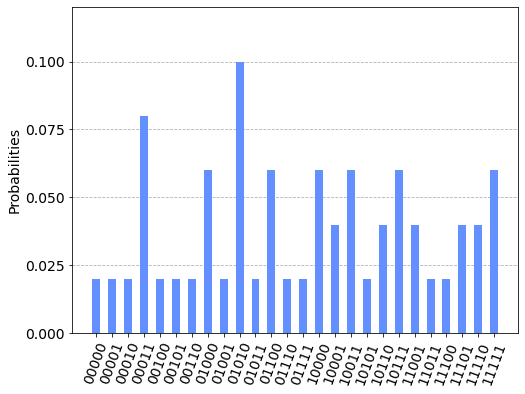

In [53]:
#IBM's simulator backend
backend = Aer.get_backend("qasm_simulator")
shots = 50

# setting the bounds for gamma and beta
bounds = ((0, 2*np.pi), (0, 2*np.pi)) 

# minimizing the function == maximizing expectation value
max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(backend,G,shots), bounds=bounds, options={'disp': False}, method = 'SLSQP')
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,shots)
get_solution(counts)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Trying with a global optimizer (the differential_evolution) from scipy gives much better resuls (idea from Mahabubul Alam, Abdullah Ash-Saki, Swaroop Ghosh paper). This optimizer also needs a lot more evaluation of the objective function, so the running time is quite larger. This is specially notable when using real hardware.

Optimal gamma, beta =  0.7058652530000882 1.297863937300526
Expectation value of the cost function =  4.44
The solution is the state [1, 0, 1, 0, 0] with a cost value of 5.0


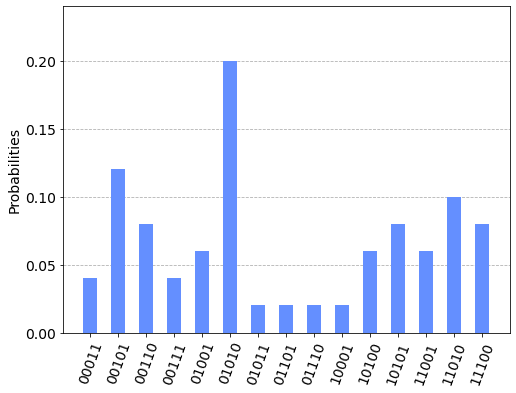

In [52]:
#Using a global optimizer:
max_expect_value = differential_evolution(expect_value_function,args=(backend,G,shots), bounds=bounds)
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,shots)
get_solution(counts)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

# Quantum Inspire

Now the same but with the quantum inspire backend . Expectation values are lower (as expected).

Optimal gamma, beta =  0.0 0.0
Expectation value of the cost function =  2.08
The solution is the state [0, 1, 0, 1] with a cost value of 4.0


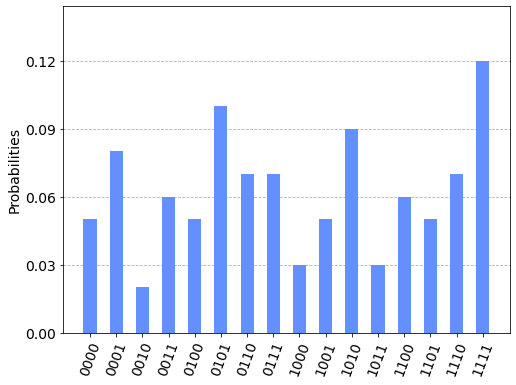

In [42]:
from quantuminspire.credentials import save_account
from quantuminspire.qiskit import QI

save_account('baeb3be4d807b3b6d170dc2d6de5c1b02b1606d1') #saves account with my API token
QI.set_authentication()

qi_backend = QI.get_backend('QX single-node simulator') #
shots = 50

# setting the bounds for gamma and beta
bounds = ((0, 2*np.pi), (0, 2*np.pi)) 

#SLSQP local minimizer
max_expect_value = minimize(expect_value_function, x0=np.random.randn(2),args=(qi_backend,G,shots), bounds=bounds, options={'disp': False}, method = 'SLSQP')
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,100)
get_solution(counts)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

Global optimizer (takes quite a long time so I did not run it yet, but it should work as good as with the IBM simulator)

In [29]:
# using the global optimizer
max_expect_value = differential_evolution(expect_value_function,args=(qi_backend,G,shots), bounds=bounds)
optimal_gamma, optimal_beta = max_expect_value['x']

print('Optimal gamma, beta = ', optimal_gamma, optimal_beta)
print('Expectation value of the cost function = ', -max_expect_value.get('fun'))

counts = quantum_circuit(G,optimal_gamma,optimal_beta,backend,100)
plot_histogram(counts,figsize = (8,6),bar_labels = False)

KeyboardInterrupt: 